In [1]:
import os
import numpy as np
from utils import load_mnist_vgg_dataset_model, plot_mnist

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
x_train, y_train, x_test, y_test, model = load_mnist_vgg_dataset_model()
all_layer_names = [layer.name for layer in model.model.layers]
model.model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "MnistVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
___________________________________________

The following preparation will be done during pre-processing: 

In [3]:
# x_test = x_test[:1000]
# y_test = y_test[:1000]

In [4]:
# prediction = model.predict(x_test[:1000])
# misclassified_mask = np.argmax(prediction, axis=1) != np.argmax(y_test[:1000], axis=1)
# np.where(misclassified_mask)

In [5]:
layer_name = "activation_12"

At query time:

In [6]:
# image_ids = [193, 412, 582, 659, 938]
# label_test = np.argmax(y_test, axis=1)
# for image_id in image_ids:
#     prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
#     plot_mnist(x_test, label_test, image_id, prediction)

In [7]:
import heapq
def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = list()
    image_samples = list()
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

In [8]:
image_ids = [659]
k_global = 20
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)
topk_activations

[[(2.2470708, (1, 1, 374)),
  (1.9390898, (0, 0, 113)),
  (1.901135, (0, 0, 358)),
  (1.8457981, (1, 0, 335)),
  (1.8241946, (1, 1, 62)),
  (1.7726848, (1, 0, 182)),
  (1.7536622, (1, 1, 129)),
  (1.7496961, (0, 0, 95)),
  (1.7491626, (1, 0, 441)),
  (1.6753774, (1, 1, 177)),
  (1.6667684, (0, 0, 46)),
  (1.6587315, (0, 1, 340)),
  (1.6440471, (0, 1, 285)),
  (1.6398696, (1, 1, 428)),
  (1.6205437, (0, 1, 365)),
  (1.614127, (0, 1, 461)),
  (1.5758138, (0, 0, 245)),
  (1.5589457, (0, 0, 45)),
  (1.5521429, (0, 1, 336)),
  (1.5128992, (0, 1, 379))]]

In [9]:
from backprop import *
import matplotlib.pyplot as plt

def bp(model, layer_name, x, masking):
    backprop = Backpropagation(model=model.model, 
                           layer_name=layer_name,
                           input_data=x,
                           masking=masking)
    heatmap, _ = backprop.compute()
    plt.imshow(heatmap[0])
    plt.axis('off')
    plt.show()
    

def sgrad(model, layer_name, x, masking):
    smoothgrad = SmoothGrad(model=model.model, 
                           layer_name=layer_name,
                           input_data=x,
                           masking=masking)
    heatmap  = smoothgrad.compute()
    plt.imshow(heatmap[0]); plt.axis('off'); plt.show()
    

def guidedbp(model, layer_name, x, masking):
    guidedbackprop = GuidedBackprop(model=model.model, 
                           layer_name=layer_name,
                           input_data=x,
                           masking=masking)
    heatmap  = guidedbackprop.compute()
    plt.imshow(heatmap[0]); plt.axis('off'); plt.show()
    

def deconv(model, layer_name, x, masking):
    deconvnet = DeconvNet(model=model.model, 
                           layer_name=layer_name,
                           input_data=x,
                           masking=masking)
    heatmap  = deconvnet.compute()
    plt.imshow(heatmap[0]); plt.axis('off'); plt.show()

In [11]:
layer = model.model.get_layer(layer_name)
masking = np.zeros(layer.output_shape[1:])
for item in topk_activations[0]:
    masking[item[1]] = 1

In [11]:
# masking is for selecting which unit to be mapped back
x = x_test[659]
x = np.expand_dims(x, axis=0)

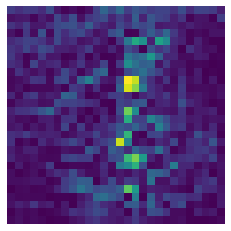

In [12]:
bp(model, layer_name, x, masking)

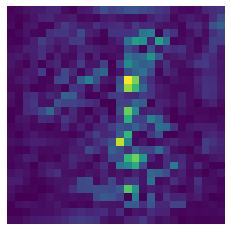

In [13]:
sgrad(model, layer_name, x, masking)

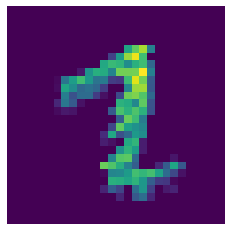

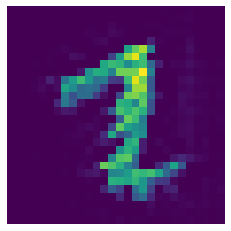

In [14]:
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

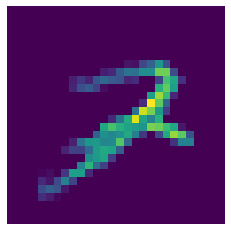

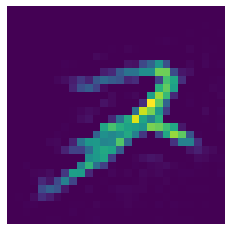

In [15]:
x = x_test[9664]
x = np.expand_dims(x, axis=0)
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

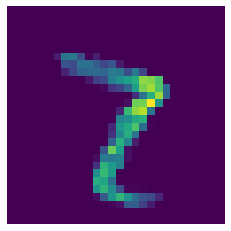

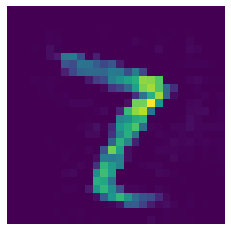

In [16]:
x = x_test[9505]
x = np.expand_dims(x, axis=0)
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

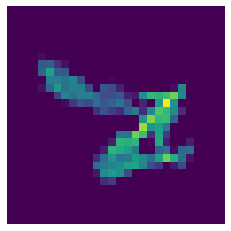

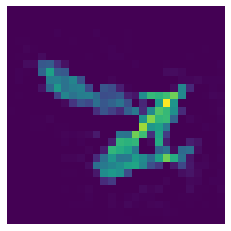

In [17]:
x = x_test[4176]
x = np.expand_dims(x, axis=0)
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

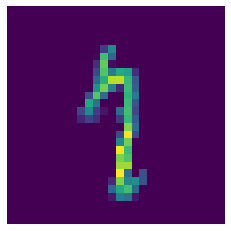

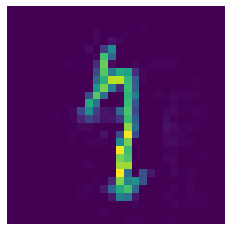

In [18]:
x = x_test[4201]
x = np.expand_dims(x, axis=0)
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

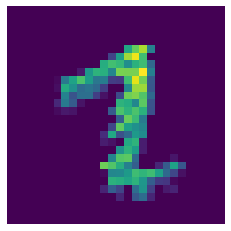

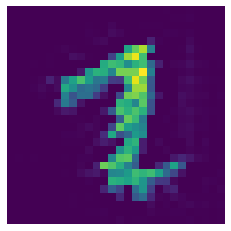

In [21]:
x = x_test[659]
x = np.expand_dims(x, axis=0)
masking = np.ones(layer.output_shape[1:])
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

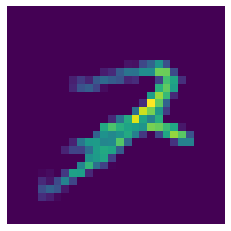

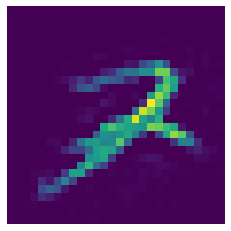

In [13]:
x = x_test[9664]
x = np.expand_dims(x, axis=0)
masking = np.ones(layer.output_shape[1:])
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

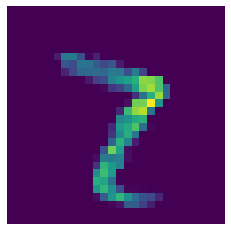

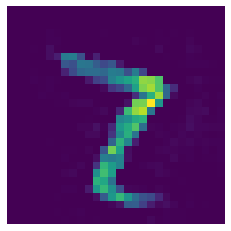

In [14]:
x = x_test[9505]
x = np.expand_dims(x, axis=0)
masking = np.ones(layer.output_shape[1:])
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

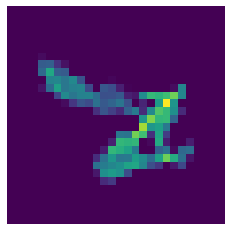

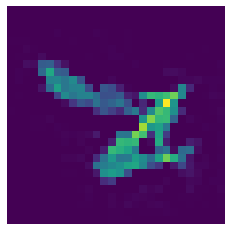

In [15]:
x = x_test[4176]
x = np.expand_dims(x, axis=0)
masking = np.ones(layer.output_shape[1:])
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)

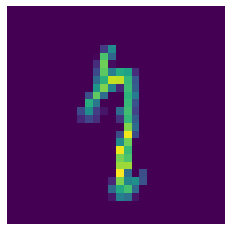

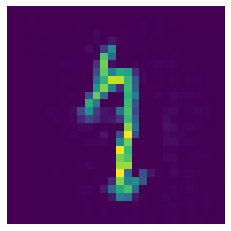

In [16]:
x = x_test[4201]
x = np.expand_dims(x, axis=0)
masking = np.ones(layer.output_shape[1:])
guidedbp(model, layer_name, x, masking)
deconv(model, layer_name, x, masking)